In [3]:
import torch
# import torchvision
import matplotlib.pyplot as plt
import numpy as np
import math
import sys
from scipy.io import savemat, loadmat
from tqdm import tqdm
from torch.nn import DataParallel
import csv
from numba import njit, jit
import pandas as pd
import os
from scipy.special import rel_entr
from sklearn.metrics import mutual_info_score
# import seaborn as sn


In [55]:
def entropy(p):
    """Calculate entropy for given probability distribution."""
    p = p[p > 0]  # Filter zero probabilities to avoid log(0)
    return -np.sum(p * np.log(p))

def mutual_information(x, y, bins=120):
    """Estimate mutual information for continuous variables."""
    c_xy = np.histogram2d(x, y, bins)[0]
    p_xy = c_xy / np.sum(c_xy)  # Joint probability distribution
    p_x = np.sum(p_xy, axis=1)  # Marginal for x
    p_y = np.sum(p_xy, axis=0)  # Marginal for y
    
    # Calculate entropies
    h_x = entropy(p_x)
    h_y = entropy(p_y)
    h_xy = entropy(p_xy.flatten())
    
    # Mutual information
    mi = h_x + h_y - h_xy
    return mi
def truncate_arrays(a, b):
    min_size = min(a.size, b.size)  # Find the size of the smaller array
    # print(min_size)
    return a.flatten()[:min_size], b.flatten()[:min_size]  # Truncate the larger one


def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [12]:
# header = ['epoch', 'channel','value']
# name = "ce"
# folder_header = "/home/sarvagya/Desktop/BCH/"+name+"/"
# csv_file = "data_"+name+".csv"
# temp_mat = "tempmatrix_"+name+".mat"
# with open(folder_header+csv_file, 'w') as f:
#     writer = csv.writer(f)
#     writer.writerow(header)
    
uae_data = {
    "scanner":[],
    "sub":[],
    "ses": [],
    "image": [],
    "UAE":[],
    "energy_map":[]
}
# print(torch.cuda.get_device_name(0))

In [13]:
img_list = []
folder = "/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/THS_images"
scanners = sorted(os.listdir(folder))
for scanner in scanners:
    subs = sorted([sub for sub in os.listdir(folder+"/"+scanner+'/') if "S0" in sub])
    if len(subs)==0:
        pass
    else:
        # print(subs)
        for sub in subs:
            # print(sub)

            sessions = sorted([ses for ses in os.listdir(folder+"/"+scanner+'/'+sub) if "M0" in ses])
            # print(sessions)
            for ses in sessions:

                print(scanner, sub, ses)

BCN S01 M01
BCN S01 M02
BCN S02 M01
BCN S02 M02
BCN S03 M01
BCN S03 M02
BCN S04 M01
BCN S04 M02
BCN S05 M01
BCN S05 M02
BSL S01 M01
BSL S01 M02
BSL S02 M01
BSL S02 M02
BSL S03 M01
BSL S03 M02
BSL S04 M01
BSL S04 M02
BSL S05 M01
BSL S05 M02
HD S01 M01
HD S01 M02
HD S02 M01
HD S02 M02
HD S03 M01
HD S03 M02
HD S04 M01
HD S04 M02
HD S05 M01
HD S05 M02
ZH S01 M01
ZH S01 M02
ZH S02 M01
ZH S02 M02
ZH S03 M01
ZH S03 M02
ZH S04 M01
ZH S04 M02
ZH S05 M01
ZH S05 M02


In [7]:
# files_images = []
# for root, dirs, files in os.walk(os.path.abspath(folder)):
#     for file in files:
#         files_images.append(os.path.join(root, file))
# print(len(files_images))

In [7]:
# img = plt.imread("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/images/BSL-002/ses-03/axial/"+img_list[90])
# print(img[:,:,0:3].shape)
# plt.imshow(img[:,:,0:3])


In [8]:
# plt.imshow(img)

In [8]:
def energy_map(f_map):
  map = np.zeros((f_map.shape[1], f_map.shape[2]))
  for i in range(f_map.shape[0]):
    map = map + f_map[i]
  map = map/f_map.shape[0]
  return map

@jit
def uae(f_map):
  f_map = f_map[0]
  value=0
  value+=np.sum(f_map)
  return value/(f_map.shape[0]*f_map.shape[1]*f_map.shape[2])

In [9]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16',pretrained=True)
# model = model.

Using cache found in /home/neuroimaging/.cache/torch/hub/pytorch_vision_v0.10.0


In [14]:
layers = [2,4,7,9,12,14,16,19,21,23,26,28,30]
value = []
idx = []
e_map = []
count = 0
for i in tqdm(range(len(scanners))):
  # for j in range(channel):
    # img = mat['newmatrix'][i,j,:,:,:]
  scanner = scanners[i]

  subs = sorted([sub for sub in os.listdir(folder+'/'+scanner+'/') if "S0" in sub])
  for sub in subs:
    sessions = sorted([ses for ses in os.listdir(folder+"/"+scanner+'/'+sub) if "M0" in ses])
            # print(sessions)
    for ses in sessions:
      image_list = sorted(os.listdir(folder+'/'+scanner+"/"+sub+'/'+ses+'/axial'))
      print(scanner, sub, ses)
      # print(image_list)
      for img_list in image_list:
        img = plt.imread(folder+'/'+scanner+"/"+sub+'/'+ses+'/axial/'+img_list)
        # print(img.shape)
        img = img[:,:,0:3]
        # img = np.rot90(img)
        img = img.reshape(-1,img.shape[2],img.shape[0],img.shape[1])
        # print(img.shape)
        img = torch.tensor(img, dtype=torch.float32)

        for k in layers:
          model_test = torch.nn.Sequential(*list(model.children())[0][:k])
            # model_test = DataParallel(model_test, device_ids=[0, 1])
            # print(model_test.device_ids)
            # img = img.cuda()
          res = model_test(img)
          res = res.cpu().detach().numpy()
          # print(res.shape)
          # temp_uae = uae(res)
          value.append(uae(res))
          # idx.append(img_list[i])
          res = np.squeeze(res)
          res_energy = energy_map(res)
          e_map.append(res_energy)
            # matrix_feature[i,j,:,:] = res_energy
          # idx = [i,j,value]
          # with open(folder_header+csv_file, 'a') as f:
          #   writer = csv.writer(f)
          #   writer.writerow(idx)
          # value = []
          # idx = []
        uae_data["scanner"].append(scanner)
        uae_data["image"].append(img_list)
        uae_data["sub"].append(sub)
        uae_data["ses"].append(ses)
        uae_data["UAE"].append(value)
        uae_data["energy_map"].append(e_map)

        value = []
        e_map = []
      # count+=1
      # print(count)



  0%|          | 0/4 [00:00<?, ?it/s]

BCN S01 M01
BCN S01 M02
BCN S02 M01
BCN S02 M02
BCN S03 M01
BCN S03 M02
BCN S04 M01
BCN S04 M02
BCN S05 M01
BCN S05 M02


 25%|██▌       | 1/4 [09:51<29:34, 591.66s/it]

BSL S01 M01
BSL S01 M02
BSL S02 M01
BSL S02 M02
BSL S03 M01
BSL S03 M02
BSL S04 M01
BSL S04 M02
BSL S05 M01
BSL S05 M02


 50%|█████     | 2/4 [19:36<19:34, 587.49s/it]

HD S01 M01
HD S01 M02
HD S02 M01
HD S02 M02
HD S03 M01
HD S03 M02
HD S04 M01
HD S04 M02
HD S05 M01
HD S05 M02


 75%|███████▌  | 3/4 [29:21<09:46, 586.42s/it]

ZH S01 M01
ZH S01 M02
ZH S02 M01
ZH S02 M02
ZH S03 M01
ZH S03 M02
ZH S04 M01
ZH S04 M02
ZH S05 M01
ZH S05 M02


100%|██████████| 4/4 [38:59<00:00, 584.75s/it]


THIS IS TO CREATE AVG MAT FILE FOR UAE VALUES

In [11]:
# savemat("/media/neuroimaging/Transcend/THS_complete_uae_data.mat", uae_data)
# data_mat_ses_1 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/BSL-002_ses-01.mat")
# data_mat_ses_2 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/BSL-002_ses-02.mat")
# data_mat_pat_2_ses_1 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/NTL-008_ses-01.mat")
# data_mat_pat_2_ses_2 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/NTL-008_ses-02.mat")
# data_mat_pat_3_ses_1 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/ZRH-004_ses-01.mat")
# data_mat_pat_3_ses_2 = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/ZRH-004_ses-02.mat")
uae_data = loadmat("/home/neuroimaging/Desktop/Sarvagya_work/Harmonization/processed_data/THS_complete_uae_data.mat")
# data_mat = uae_data

In [12]:
# uae_values_ses_1 = data_mat_ses_1["UAE"].squeeze()
# uae_values_ses_1 = np.round(uae_values_ses_1, decimals=4)

# uae_values_ses_2 = data_mat_ses_2["UAE"].squeeze()
# uae_values_ses_2 = np.round(uae_values_ses_2, decimals=4)

# uae_values_pat_1_ses_1 = data_mat_pat_2_ses_1["UAE"].squeeze()
# uae_values_pat_1_ses_1 = np.round(uae_values_pat_1_ses_1, decimals=4)

# uae_values_pat_1_ses_2 = data_mat_pat_2_ses_2["UAE"].squeeze()
# uae_values_pat_1_ses_2 = np.round(uae_values_pat_1_ses_2, decimals=4)

# uae_values_pat_2_ses_1 = data_mat_pat_3_ses_1["UAE"].squeeze()
# uae_values_pat_2_ses_1 = np.round(uae_values_pat_2_ses_1, decimals=4)

# uae_values_pat_2_ses_2 = data_mat_pat_3_ses_2["UAE"].squeeze()
# uae_values_pat_2_ses_2 = np.round(uae_values_pat_2_ses_2, decimals=4)
# print(np.unique(uae_data["UAE"]))
print(len(uae_data["UAE"]))
uae_data["UAE"] = np.array(uae_data["UAE"])
uae_data["UAE"].reshape(len(uae_data["UAE"]), 13)
print(uae_data["UAE"].shape)

6085
(6085, 13)


In [15]:
print(np.unique(uae_data["scanner"]))
print(np.unique(uae_data["sub"]))
print(np.unique(uae_data["ses"]))

['BCN' 'BSL' 'HD ' 'ZH ']
['S01' 'S02' 'S03' 'S04' 'S05']
['M01' 'M02']


In [34]:
matrices = {}
for scanner in np.unique(uae_data["scanner"]):
    idx_scanner = np.where(np.array(uae_data["scanner"]) == scanner)[0]
    print(idx_scanner[0], idx_scanner[-1])
    new_dict_for_each_scanner = {key: values[idx_scanner[0]:idx_scanner[-1]+1] for key, values in uae_data.items()}
    for sub in np.unique(uae_data["sub"]):
        idx_sub = np.where(np.array(new_dict_for_each_scanner["sub"]) == sub)[0]
        sessions = np.unique(new_dict_for_each_scanner["ses"][idx_sub[0]:idx_sub[-1]+1])
        
        new_dict_for_each_sub = {key: values[idx_sub[0]:idx_sub[-1]+1] for key, values in new_dict_for_each_scanner.items()}

        for ses in sessions:

            idx_ses = np.where(np.array(new_dict_for_each_sub["ses"]) == ses)[0]
            print(ses, sub, scanner, idx_ses[0], idx_ses[-1], idx_sub[0], idx_sub[-1])

            new_dict_for_each_ses_for_above_sub_each_scanner = {key: values[idx_ses[0]:idx_ses[-1]+1] for key, values in new_dict_for_each_sub.items()}

            # exec(sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1]+" = []")
            # print(sub.split("-")[0]+sub.split("-")[1][-1]+ses.split("-")[0]+"_"+ses.split("-")[1])

    #         # exec(sub.split("-")[0]+ses.split("-")[0]+"_"+ses.split("-")[1]+".append()")

            print(new_dict_for_each_ses_for_above_sub_each_scanner["UAE"].shape)
            matrix_key = scanner+sub+ses
            # print(matrix_key)
            matrices[matrix_key] = new_dict_for_each_ses_for_above_sub_each_scanner["UAE"]


0 1521
M01 S01 BCN 0 151 0 304
(152, 13)
M02 S01 BCN 152 304 0 304
(153, 13)
M01 S02 BCN 0 152 305 609
(153, 13)
M02 S02 BCN 153 304 305 609
(152, 13)
M01 S03 BCN 0 151 610 914
(152, 13)
M02 S03 BCN 152 304 610 914
(153, 13)
M01 S04 BCN 0 151 915 1218
(152, 13)
M02 S04 BCN 152 303 915 1218
(152, 13)
M01 S05 BCN 0 151 1219 1521
(152, 13)
M02 S05 BCN 152 302 1219 1521
(151, 13)
1522 3043
M01 S01 BSL 0 151 0 304
(152, 13)
M02 S01 BSL 152 304 0 304
(153, 13)
M01 S02 BSL 0 152 305 610
(153, 13)
M02 S02 BSL 153 305 305 610
(153, 13)
M01 S03 BSL 0 151 611 914
(152, 13)
M02 S03 BSL 152 303 611 914
(152, 13)
M01 S04 BSL 0 151 915 1218
(152, 13)
M02 S04 BSL 152 303 915 1218
(152, 13)
M01 S05 BSL 0 150 1219 1521
(151, 13)
M02 S05 BSL 151 302 1219 1521
(152, 13)
3044 4564
M01 S01 HD  0 151 0 303
(152, 13)
M02 S01 HD  152 303 0 303
(152, 13)
M01 S02 HD  0 152 304 608
(153, 13)
M02 S02 HD  153 304 304 608
(152, 13)
M01 S03 HD  0 151 609 913
(152, 13)
M02 S03 HD  152 304 609 913
(153, 13)
M01 S04 HD 

In [37]:
len(list(matrices.keys()))

40

In [35]:
# matrix_sub = list(matrices.keys())
# matrices_probability = {}

# for i in range(len(matrix_sub)):

#     print(matrix_sub[i])

#     test_matrix = matrices[matrix_sub[i]]
#     print(test_matrix.shape)

#     uae_values_ses = np.round(test_matrix, decimals=4)
#     print(uae_values_ses)
#     print(uae_values_ses.shape)

#     for i in range(test_matrix.shape[1]):

#         print(uae_values_ses[:,i].shape)

#         unique_ses, counts_ses = np.unique(uae_values_ses[:,i], return_counts=True)

#         pdf_ses = counts_ses/counts_ses.shape[0]

        # print(pdf_ses)
        # print(pdf_ses.shape)

    # matrix_key = f'matrix_{matrix_sub[i]+"_probability"}'
    # matrices_probability[matrix_key] = 

In [56]:
matrix_sub = list(matrices.keys())
num_matrices = len(list(matrices.keys()))
mi_matrix = np.zeros((num_matrices, num_matrices, 13))
print(matrix_sub)

for i in tqdm(range(len(matrix_sub))):
    print(matrix_sub[i])
    for j in range(i, len(matrix_sub)):
        for k in range(13):
            if matrices[matrix_sub[i]][:,k].shape != matrices[matrix_sub[j]][:,k].shape:
                # print(matrices[matrix_sub[i]][:,k].shape)
                # print(matrices[matrix_sub[j]][:,k].shape)
                x, y = truncate_arrays(matrices[matrix_sub[i]][:,k], matrices[matrix_sub[j]][:,k])
                # print(x.shape)
                # print(y.shape)
                mi = mutual_information(x, y, 1000)
            else:
                mi = mutual_information(matrices[matrix_sub[i]][:,k], matrices[matrix_sub[j]][:,k], 1000)
            mi_matrix[i, j, k] = mi
            mi_matrix[j, i, k] = mi  # Fill both (i, j) and (j, i) since MI is symmetric



# print(temp_x)

['BCNS01M01', 'BCNS01M02', 'BCNS02M01', 'BCNS02M02', 'BCNS03M01', 'BCNS03M02', 'BCNS04M01', 'BCNS04M02', 'BCNS05M01', 'BCNS05M02', 'BSLS01M01', 'BSLS01M02', 'BSLS02M01', 'BSLS02M02', 'BSLS03M01', 'BSLS03M02', 'BSLS04M01', 'BSLS04M02', 'BSLS05M01', 'BSLS05M02', 'HD S01M01', 'HD S01M02', 'HD S02M01', 'HD S02M02', 'HD S03M01', 'HD S03M02', 'HD S04M01', 'HD S04M02', 'HD S05M01', 'HD S05M02', 'ZH S01M01', 'ZH S01M02', 'ZH S02M01', 'ZH S02M02', 'ZH S03M01', 'ZH S03M02', 'ZH S04M01', 'ZH S04M02', 'ZH S05M01', 'ZH S05M02']


  0%|          | 0/40 [00:00<?, ?it/s]

BCNS01M01


  2%|▎         | 1/40 [00:03<02:16,  3.49s/it]

BCNS01M02


  5%|▌         | 2/40 [00:06<02:07,  3.36s/it]

BCNS02M01


  8%|▊         | 3/40 [00:09<02:00,  3.26s/it]

BCNS02M02


 10%|█         | 4/40 [00:12<01:54,  3.18s/it]

BCNS03M01


 12%|█▎        | 5/40 [00:15<01:48,  3.10s/it]

BCNS03M02


 15%|█▌        | 6/40 [00:18<01:42,  3.02s/it]

BCNS04M01


 18%|█▊        | 7/40 [00:21<01:37,  2.94s/it]

BCNS04M02


 20%|██        | 8/40 [00:24<01:31,  2.87s/it]

BCNS05M01


 22%|██▎       | 9/40 [00:26<01:26,  2.80s/it]

BCNS05M02


 25%|██▌       | 10/40 [00:29<01:21,  2.73s/it]

BSLS01M01


 28%|██▊       | 11/40 [00:31<01:16,  2.65s/it]

BSLS01M02


 30%|███       | 12/40 [00:34<01:12,  2.58s/it]

BSLS02M01


 32%|███▎      | 13/40 [00:36<01:07,  2.50s/it]

BSLS02M02


 35%|███▌      | 14/40 [00:38<01:02,  2.41s/it]

BSLS03M01


 38%|███▊      | 15/40 [00:41<00:58,  2.34s/it]

BSLS03M02


 40%|████      | 16/40 [00:43<00:54,  2.26s/it]

BSLS04M01


 42%|████▎     | 17/40 [00:45<00:50,  2.18s/it]

BSLS04M02


 45%|████▌     | 18/40 [00:47<00:46,  2.10s/it]

BSLS05M01


 48%|████▊     | 19/40 [00:48<00:42,  2.03s/it]

BSLS05M02


 50%|█████     | 20/40 [00:50<00:38,  1.94s/it]

HD S01M01


 52%|█████▎    | 21/40 [00:52<00:35,  1.85s/it]

HD S01M02


 55%|█████▌    | 22/40 [00:53<00:31,  1.77s/it]

HD S02M01


 57%|█████▊    | 23/40 [00:55<00:28,  1.68s/it]

HD S02M02


 60%|██████    | 24/40 [00:56<00:25,  1.59s/it]

HD S03M01


 62%|██████▎   | 25/40 [00:58<00:22,  1.51s/it]

HD S03M02


 65%|██████▌   | 26/40 [00:59<00:19,  1.43s/it]

HD S04M01


 68%|██████▊   | 27/40 [01:00<00:17,  1.35s/it]

HD S04M02


 70%|███████   | 28/40 [01:01<00:15,  1.27s/it]

HD S05M01


 72%|███████▎  | 29/40 [01:02<00:13,  1.19s/it]

HD S05M02


 75%|███████▌  | 30/40 [01:03<00:11,  1.10s/it]

ZH S01M01


 78%|███████▊  | 31/40 [01:04<00:09,  1.02s/it]

ZH S01M02


 80%|████████  | 32/40 [01:04<00:07,  1.07it/s]

ZH S02M01


 82%|████████▎ | 33/40 [01:05<00:05,  1.17it/s]

ZH S02M02


 85%|████████▌ | 34/40 [01:06<00:04,  1.29it/s]

ZH S03M01


 88%|████████▊ | 35/40 [01:06<00:03,  1.42it/s]

ZH S03M02


 90%|█████████ | 36/40 [01:07<00:02,  1.63it/s]

ZH S04M01


 92%|█████████▎| 37/40 [01:07<00:01,  1.88it/s]

ZH S04M02


 98%|█████████▊| 39/40 [01:07<00:00,  2.75it/s]

ZH S05M01
ZH S05M02


100%|██████████| 40/40 [01:08<00:00,  1.70s/it]


In [57]:
mi_matrix.shape
# x

(40, 40, 13)

/tmp/ipykernel_888583/2326633464.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


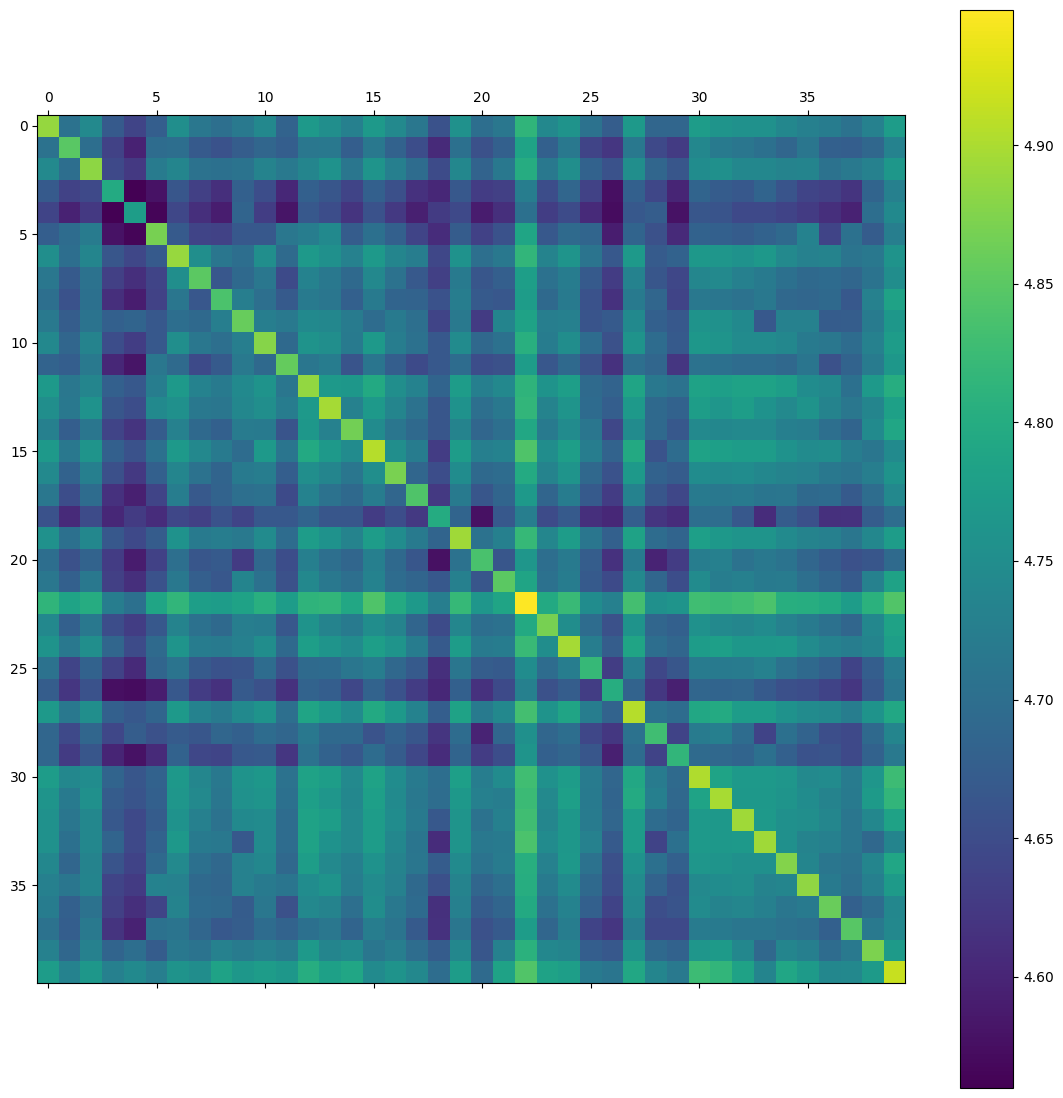

In [58]:
# plt.matshow(mi_matrix[:,:,12])


# alpha = ['BSL0201', 'BSL0202', 'BSL0203', 'NTL0401', 'NTL0402', 'NTL0403', 'NTL0801', 'NTL0802', 'NTL0803', 'ZRH0401', 'ZRH0402', 'ZRH0403']

data = mi_matrix[:,:,1]

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(data)
fig.colorbar(cax)

# ax.set_xticklabels(alpha)
# ax.set_yticklabels(alpha)

# ax.set_xticks(np.arange(len(alpha)), labels=alpha)
# ax.set_yticks(np.arange(len(alpha)), labels=alpha)

fig.show()

(40, 40)


/tmp/ipykernel_888583/1107915850.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


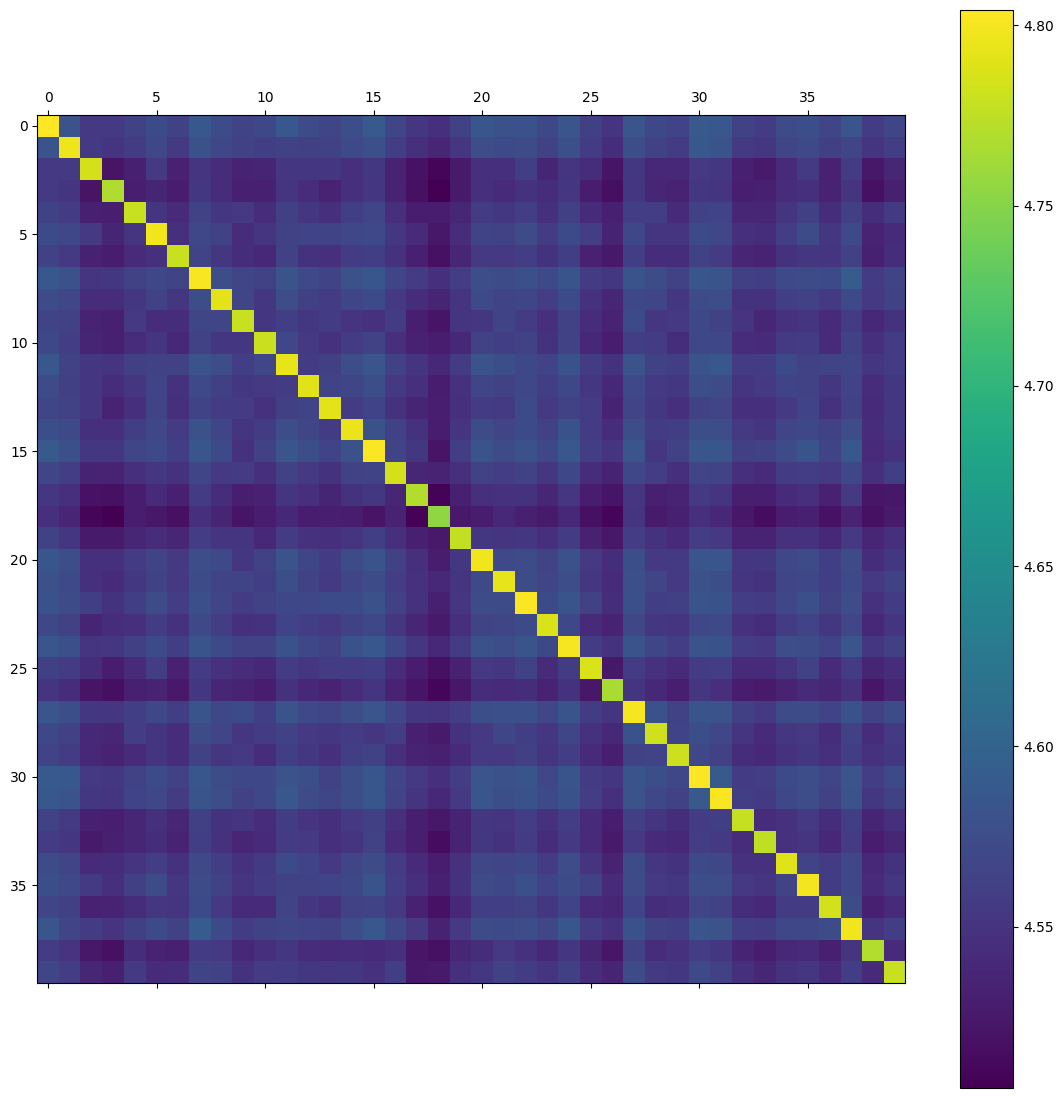

In [62]:
y = np.average(mi_matrix, axis=2)
print(y.shape)

# alpha = ['BSL0201', 'BSL0202', 'BSL0203', 'NTL0401', 'NTL0402', 'NTL0403', 'NTL0801', 'NTL0802', 'NTL0803', 'ZRH0401', 'ZRH0402', 'ZRH0403']

data = y

fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(data)
fig.colorbar(cax)

# ax.set_xticks(np.arange(len(alpha)), labels=alpha)
# ax.set_yticks(np.arange(len(alpha)), labels=alpha)

fig.show()

In [251]:
unique_ses_1, counts_ses_1 = np.unique(uae_values_ses_1, return_counts=True)
unique_ses_2, counts_ses_2 = np.unique(uae_values_ses_2, return_counts=True)
unique_pat_1_ses_1, counts_pat_1_ses_1 = np.unique(uae_values_pat_1_ses_1, return_counts=True)
unique_pat_1_ses_2, counts_pat_1_ses_2 = np.unique(uae_values_pat_1_ses_2, return_counts=True)

unique_pat_2_ses_1, counts_pat_2_ses_1 = np.unique(uae_values_pat_2_ses_1, return_counts=True)
unique_pat_2_ses_2, counts_pat_2_ses_2 = np.unique(uae_values_pat_2_ses_2, return_counts=True)

In [252]:
pdf_ses_1 = counts_ses_1/counts_ses_1.shape[0]
pdf_ses_2 = counts_ses_2/counts_ses_2.shape[0]
pdf_pat_1_ses_1 = counts_pat_1_ses_1/counts_pat_1_ses_1.shape[0]
pdf_pat_1_ses_2 = counts_pat_1_ses_2/counts_pat_1_ses_2.shape[0]

pdf_pat_2_ses_1 = counts_pat_2_ses_1/counts_pat_2_ses_1.shape[0]
pdf_pat_2_ses_2 = counts_pat_2_ses_2/counts_pat_2_ses_2.shape[0]

In [ ]:
print("KL of session 1 and session 2: ", sum(rel_entr(pdf_ses_1, pdf_ses_2[1:])))
print("KL of session 2 and session 1: ", sum(rel_entr(pdf_ses_2[1:], pdf_ses_1)))
print("KL of session 1 and patient 2 session 1: ", sum(rel_entr(pdf_ses_1, pdf_pat_1_ses_1[2:])))
print("KL of patient 2 session 1 and session 1: ", sum(rel_entr(pdf_pat_1_ses_1[2:], pdf_ses_1)))
print("KL of session 2 and patient 2 session 1: ", sum(rel_entr(pdf_ses_2, pdf_pat_1_ses_1[1:])))
print("KL of patient 2 session 1 and session 2: ", sum(rel_entr(pdf_pat_1_ses_1[1:], pdf_ses_2)))

print("KL of patient 2 session 1 and patient 2 session 2: ", sum(rel_entr(pdf_pat_1_ses_1, pdf_pat_1_ses_2[3:])))
print("KL of patient 2 session 2 and patient 2 session 1: ", sum(rel_entr(pdf_pat_1_ses_2[3:], pdf_pat_1_ses_1)))

print("KL of patient 3 session 1 and patient 3 session 2: ", sum(rel_entr(pdf_pat_2_ses_1, pdf_pat_2_ses_2[3:])))
print("KL of patient 3 session 2 and patient 3 session 1: ", sum(rel_entr(pdf_pat_2_ses_2[3:], pdf_pat_2_ses_1)))

print("KL of patient 3 session 1 and patient 1 session 1: ", sum(rel_entr(pdf_pat_2_ses_1[4:], pdf_ses_1)))
print("KL of patient 1 session 1 and patient 3 session 1: ", sum(rel_entr(pdf_ses_1, pdf_pat_2_ses_1[4:])))

print("KL of patient 3 session 1 and patient 2 session 1: ", sum(rel_entr(pdf_pat_2_ses_1[2:], pdf_pat_1_ses_1)))
print("KL of patient 2 session 1 and patient 3 session 1: ", sum(rel_entr(pdf_pat_1_ses_1, pdf_pat_2_ses_1[2:])))

In [260]:
pat_0_ses = list(pdf_ses_1.flatten()) + list(pdf_ses_2.flatten())

pat_1_ses = list(pdf_pat_1_ses_1.flatten()) + list(pdf_pat_1_ses_2.flatten())

pat_2_ses = list(pdf_pat_2_ses_1.flatten()) + list(pdf_pat_2_ses_2.flatten())

In [ ]:
len(pat_0_ses)

In [ ]:
bins = np.linspace(0, 0.2, 10)

plt.hist(pat_0_ses, bins, label='x')
plt.hist(pat_1_ses, bins, label='y')
plt.hist(pat_2_ses, bins, label='z')
plt.legend(loc='upper right')
plt.show()

In [ ]:
max(pdf_pat_1_ses_1)

In [ ]:
x[:,0]